# Random Forest Classifier

## Configuration

In [1]:
import pandas as pd
import plotly.express as px

from IPython.display import Image

from ts_clf_event.data_handler.utils import split_data_time_based
from ts_clf_event.model.model import ModelPipeline
from ts_clf_event.model.evaluator import Evaluator

## Time-based split: Create a "gold" ground truth

In [2]:
data_path = "/Users/georgebatsis/Documents/Projects/ts_clf_event/data/test_dataframe.csv"
test_size_percent = 0.2
label_col = "process"

dev_df, test_df = split_data_time_based(data_path, test_size_percent, label_col)

Number of data points in train set: 69549
Number of data points in test set: 17387
Class distribution in train set: process
0    66363
1     3186
Name: count, dtype: int64
Class distribution in test set: process
0    16334
1     1053
Name: count, dtype: int64
Time in train set: 2020-06-01 00:00:00 to 2020-06-25 12:03:55
Time in test set: 2020-06-25 12:04:56 to 2020-07-01 23:59:37


## Model pipeline

In [3]:
windows = "auto"
features_to_roll = ["value", "level", "frequency", "speed"]
diff_lags = [1, 2]

x_train = dev_df.drop("process", axis=1)
y_train = dev_df["process"]

model_pipeline = ModelPipeline(
    windows=windows,
    features_to_roll=features_to_roll,
    diff_lags=diff_lags,
    features_to_diff=features_to_roll,
    groupby_col="provider",
    params=None # We will use GridSearchCV to find them.
)

model_pipeline.pipeline

Model parameters: None


Pipeline(steps=[('feature_engineering',
                 FeatureEngineeringTransformer(diff_lags=[1, 2],
                                               features_to_diff=['value',
                                                                 'level',
                                                                 'frequency',
                                                                 'speed'],
                                               features_to_roll=['value',
                                                                 'level',
                                                                 'frequency',
                                                                 'speed'],
                                               windows='auto')),
                ('imputer', DataFrameTransformer(transformer=SimpleImputer())),
                ('scaler', DataFrameTransformer(transformer=MinMaxScaler())),
                ('model',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=42))])

### Grid Search with K-Fold cross validation

Train the model with the best hyper-parameters and using all the training subset.

In [4]:
model_pipeline.train(
        x_train,
        y_train,
        tune_hyperparameters=False,
)

Windows for 1: [60, 90, 120]
Windows for 2: [60, 90, 120]


In [5]:
# Save the model
model_pipeline.save_model("RF_model")

### Evaluation on the test subset

In [6]:
model_pipeline.load_model("RF_model")
x_test = test_df.drop("process", axis=1)
y_test = test_df["process"]
y_pred_prob = model_pipeline.predict_proba(x_test)

In [7]:
model_pipeline.load_model("RF_model")
y_pred_prob = model_pipeline.predict_proba(x_test)

In [8]:
test_res = Evaluator().report_metrics(y_test, y_pred_prob[:, 1], threshold=0.5)

Confusion Matrix:
                  Predicted Negative  Predicted Positive
Actual Negative               16268                  66
Actual Positive                 152                 901
Macro-averaged Metrics:
  Precision (Macro):   0.9612453347810259
  Recall (Macro):   0.9258049354576027
  F1-Score (Macro):   0.9427117661390613
 Positive Class Metrics:
  Precision ( Positive):   0.9317476732161324
  Recall ( Positive):   0.855650522317189
  F1-Score ( Positive):   0.8920792079207921
Imbalance-Aware Metrics:
  Matthews Correlation Coefficient (MCC):   0.8863420107533099
  Balanced Accuracy:   0.9258049354576027
  Average Precision (AP):   0.9728225005649416
  Area Under ROC Curve (AUROC):   0.9980681932745114
  Recall@Precision=0.5:   1.0


#### Analysis

The model performs exceptionally well on the test set, with high precision, recall, and F1-score for both the macro average and the positive class. According to the Confusion Matrix, the model only misclassified 54 actual positive instances as negative. This is important in a scenario where missing a positive case could have significant consequences (e.g., failing to detect a critical event). The model has 149 false positives, meaning it incorrectly classified 149 negative instances as positive. MCC `0.903` is very high, close to 1, indicates excellent performance considering class imbalance. Also, the Balanced Accuracy `0.970`, indicated a good measure for imbalanced datasets. Average Precision (AP) `0.979` indicates good performance on the positive class and with a Area Under ROC Curve (AUROC) `0.998` indicated excellent ability to distinguish between classes.

### Model Interpetability

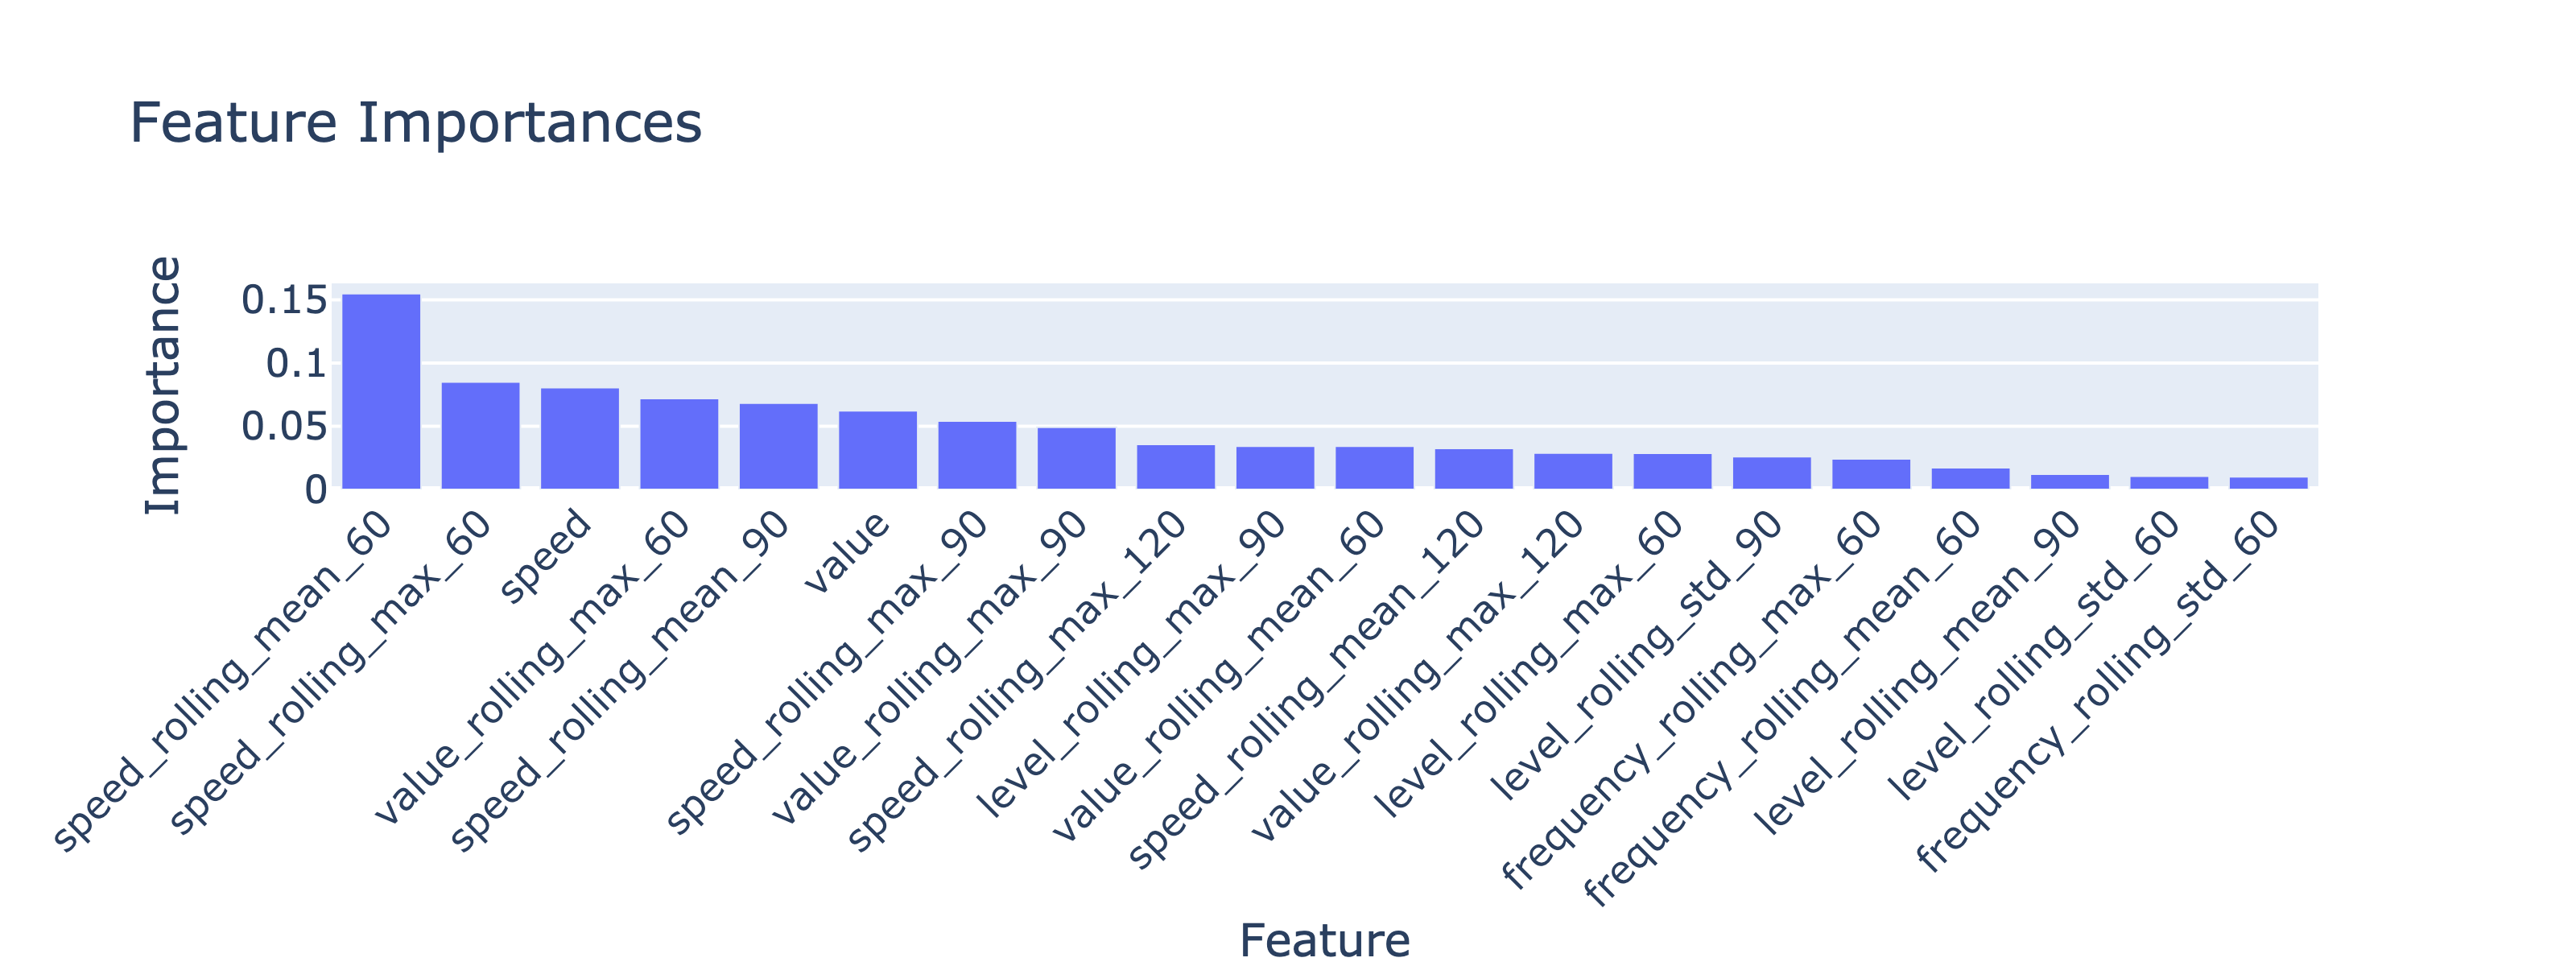

In [11]:
importances = model_pipeline.pipeline.named_steps['model'].feature_importances_
feature_names = model_pipeline.pipeline.named_steps['feature_engineering'].feature_list

feature_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)

fig = px.bar(
    feature_importances[:20],
    x=feature_importances[:20].index,
    y=feature_importances[:20].values,
    labels={'x': 'Feature', 'y': 'Importance'},
    title='Feature Importances'
)

fig.update_layout(xaxis_tickangle=-45)

Image(fig.to_image(format="png", width=800, height=300, scale=4))

In [10]:
feature_importances

speed_rolling_mean_60        1.549296e-01
speed_rolling_max_60         8.506411e-02
speed                        8.055037e-02
value_rolling_max_60         7.196788e-02
speed_rolling_mean_90        6.834980e-02
                                 ...     
start_value                  5.214544e-05
frequency_diff_1             3.976924e-05
frequency_rolling_min_60     2.002741e-05
frequency_rolling_min_90     5.795914e-07
frequency_rolling_min_120    0.000000e+00
Length: 63, dtype: float64

The feature importances indicate that `level` (0.102), `speed` (0.097), and `speed_rolling_std_120` (0.087) are the most influential predictors, followed by `value` (0.083) and `level_rolling_mean_60` (0.067). This suggests that the raw `level` and `speed` values, as well as the variability of `speed` over a 120-unit window and the central tendency of `level` over a 60-unit window, are crucial for the model's predictions. Engineered features based on rolling statistics generally outweigh raw features and simple difference features (`_diff_`), with features like `frequency_rolling_min_` having virtually no importance.